# Contexte du projet – Projet 10
___
**Objectif** : développer une première version d’un système de recommandation de contenu pour l’application My Content.
___
La startup My Content souhaite encourager la lecture en recommandant des articles pertinents à ses utilisateurs. Dans cette phase de MVP (Minimum Viable Product), l’objectif est de mettre en place :

un système de recommandation efficace (filtrage collaboratif et/ou basé contenu),

une application simple permettant d’afficher les recommandations,

une architecture déployable sur Azure via une fonction serverless.

Les données utilisées sont publiques et simulées, représentant des interactions entre des utilisateurs et des articles.

In [1]:
############################
# Importation des librairies
############################

# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Système de fichiers
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]      = "1"

# Affichage dans Jupyter
from IPython.display import display

# fichier des fonctions
import fonctions as fc
from fonctions import split_temporal, train_test_svd_temporal


In [2]:
# Hyper-paramètres
CUT_OFF          = None            # None pour quantile 0.8 automatique
PERCENTILE_Q     = 0.8             # utilisé si CUT_OFF=None
K_RECS           = 5               # Top-K recommandations
ALPHA_HYBRIDE    = 0.7             # mix content/collab dans hybrid

In [3]:
# Définir le chemin vers les données
DATA_PATH = "../data/"

# Chargement des fichiers CSV
articles = pd.read_csv(os.path.join(DATA_PATH, "articles_metadata.csv"))
clicks_sample = pd.read_csv(os.path.join(DATA_PATH, "clicks_sample.csv"))

## Explorations des données

In [4]:
# Aperçu des 5 premières lignes
print("Aperçu des articles :")
display(articles.head())

print("\nAperçu des interactions (clicks_sample) :")
display(clicks_sample.head())

Aperçu des articles :


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162



Aperçu des interactions (clicks_sample) :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [5]:
# Dimension des datasets
print(f"Articles : {articles.shape[0]} lignes, {articles.shape[1]} colonnes")
print(f"Clicks sample : {clicks_sample.shape[0]} lignes, {clicks_sample.shape[1]} colonnes")

Articles : 364047 lignes, 5 colonnes
Clicks sample : 1883 lignes, 12 colonnes


In [6]:
# Liste des colonnes disponibles
print("Colonnes dans articles:")
print(articles.columns.tolist())

print("\nColonnes dans clicks_sample:")
print(clicks_sample.columns.tolist())

Colonnes dans articles:
['article_id', 'category_id', 'created_at_ts', 'publisher_id', 'words_count']

Colonnes dans clicks_sample:
['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']


In [7]:
# Types de données
print("Types de données - Articles :")
print(articles.dtypes)

print("\nTypes de données - Clicks sample :")
print(clicks_sample.dtypes)

Types de données - Articles :
article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

Types de données - Clicks sample :
user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object


In [8]:
# Vérification des valeurs manquantes
print("Valeurs manquantes - Articles :")
display(articles.isnull().sum())

print("\nValeurs manquantes - Clicks sample :")
display(clicks_sample.isnull().sum())

Valeurs manquantes - Articles :


article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64


Valeurs manquantes - Clicks sample :


user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

In [9]:
# Statistiques descriptives
print("Statistiques - Articles :")
display(articles.describe())

print("\nStatistiques - Clicks sample :")
display(clicks_sample.describe())

Statistiques - Articles :


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000



Statistiques - Clicks sample :


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


## Analyse Univarié
- Objectif : décrire les variables indépendamment

___
### articles_metadata.csv
___

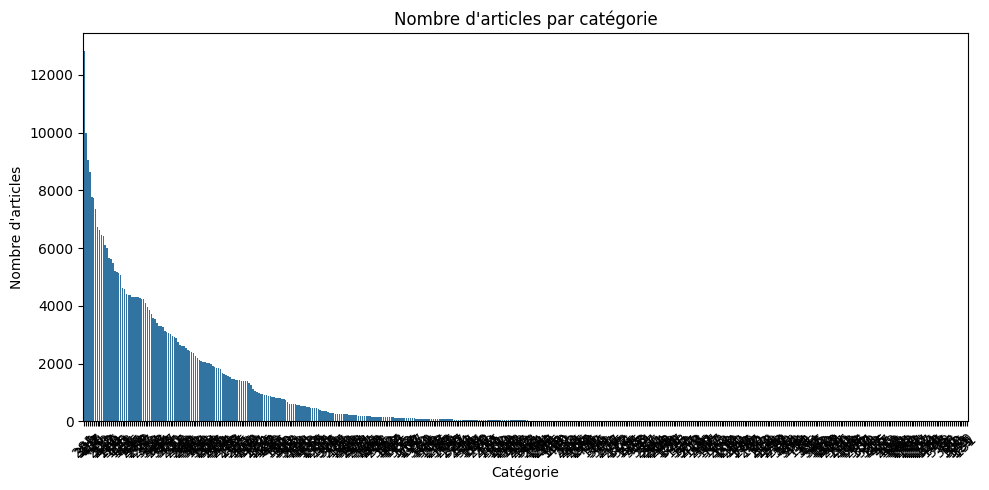

In [10]:
# Nombre d’articles par "category_id"
plt.figure(figsize=(10, 5))
sns.countplot(data=articles, x="category_id", order=articles["category_id"].value_counts().index)
plt.title("Nombre d'articles par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45) # reste ilisible
plt.tight_layout()
plt.show()

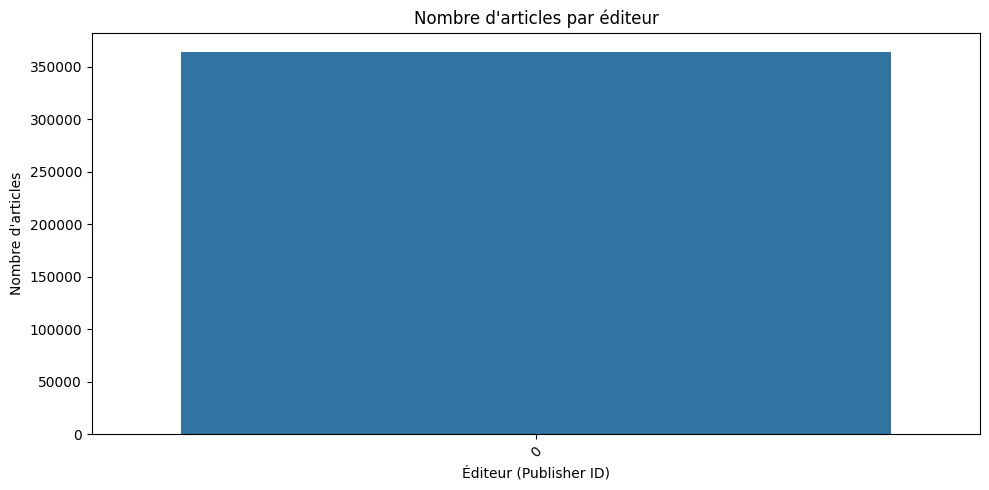

In [11]:
# Nombre d’articles par "publisher_id"
plt.figure(figsize=(10, 5))
sns.countplot(data=articles, x="publisher_id", order=articles["publisher_id"].value_counts().index)
plt.title("Nombre d'articles par éditeur")
plt.xlabel("Éditeur (Publisher ID)")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

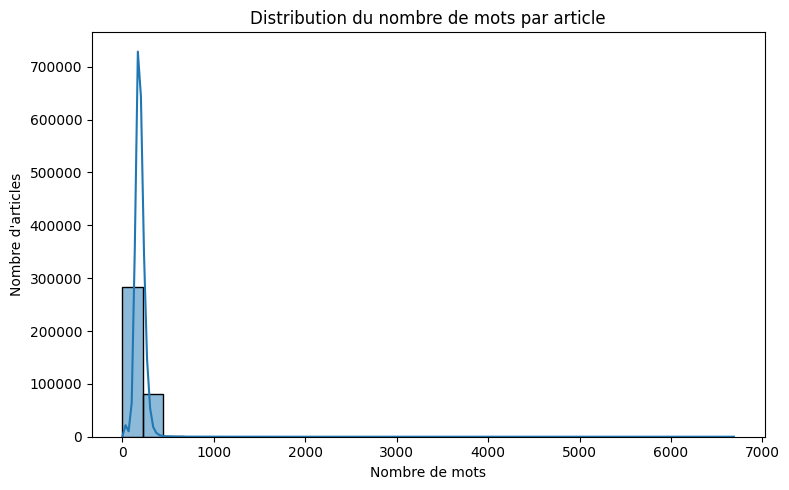

In [12]:
# Distribution du nombre de mots par article (words_count)
plt.figure(figsize=(8, 5))
sns.histplot(articles["words_count"], bins=30, kde=True)
plt.title("Distribution du nombre de mots par article")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.tight_layout()
plt.show()

___
### clicks_sample.csv
___

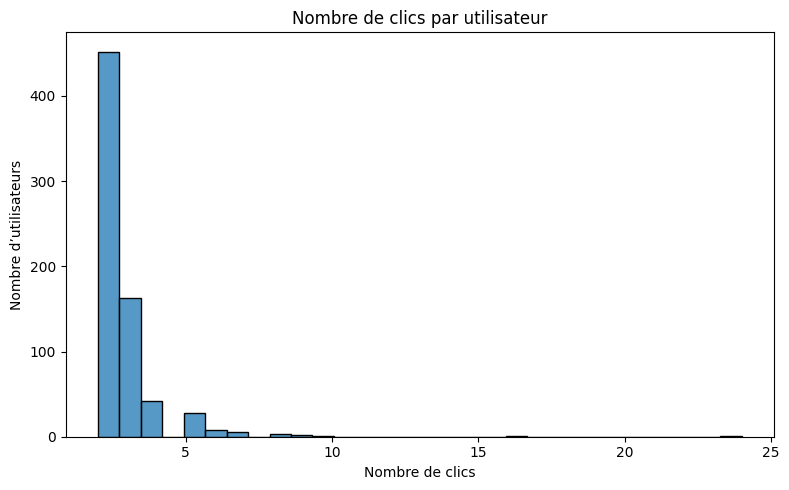

In [13]:
# Nombre de clics par utilisateur "user_id"
user_click_counts = clicks_sample["user_id"].value_counts()

plt.figure(figsize=(8, 5))
sns.histplot(user_click_counts, bins=30, kde=False)
plt.title("Nombre de clics par utilisateur")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d’utilisateurs")
plt.tight_layout()
plt.show()

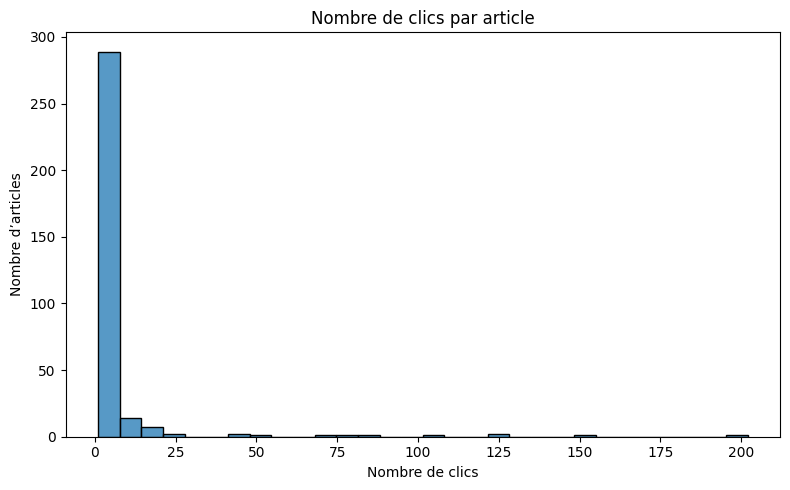

In [14]:
# Nombre de clics par article "click_article_id"
article_click_counts = clicks_sample["click_article_id"].value_counts()

plt.figure(figsize=(8, 5))
sns.histplot(article_click_counts, bins=30, kde=False)
plt.title("Nombre de clics par article")
plt.xlabel("Nombre de clics")
plt.ylabel("Nombre d’articles")
plt.tight_layout()
plt.show()

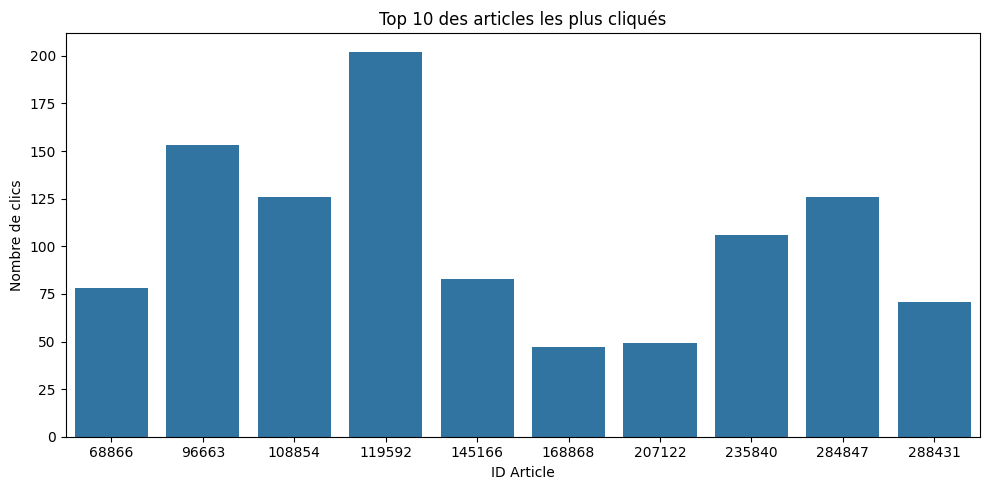

In [15]:
# Articles les plus populaires (Top 10)
top_articles = article_click_counts.head(10)
top_articles = top_articles.reset_index()
top_articles.columns = ["article_id", "nb_clicks"]

plt.figure(figsize=(10, 5))
sns.barplot(data=top_articles, x="article_id", y="nb_clicks")
plt.title("Top 10 des articles les plus cliqués")
plt.xlabel("ID Article")
plt.ylabel("Nombre de clics")
plt.tight_layout()
plt.show()

## Analyse multivarié
- Objectif : croiser les variables

___
### Fusion des deux jeux de données
___

In [16]:
df = clicks_sample.merge(articles, left_on="click_article_id", right_on="article_id", how="left")
print("Dimensions du DataFrame fusionné :", df.shape)
display(df.head(20))

Dimensions du DataFrame fusionné : (1883, 17)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,157541,281,1506800518000,0,280
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,68866,136,1506816482000,0,226
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,235840,375,1506807839000,0,159
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,96663,209,1506788025000,0,206
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,119592,247,1506784316000,0,239
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2,30970,26,1506773595000,0,216
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1,236065,375,1506699339000,0,150
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1,236294,375,1506786023000,0,151
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1,48915,92,1505828265000,0,163
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1,44488,81,1506762023000,0,162


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
 12  article_id           1883 non-null   int64
 13  category_id          1883 non-null   int64
 14  created_at_ts        1883 non-null   int64
 15  publisher_id         1883 non-null   int64
 16  words_count          188

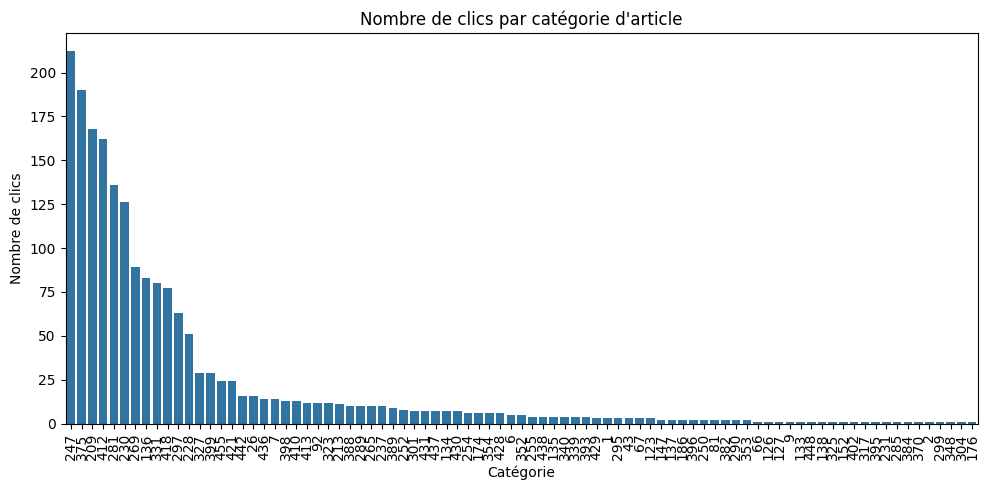

In [18]:
# Nombre moyen de clics par catégorie d’article
cat_clicks = df.groupby("category_id")["click_article_id"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=cat_clicks.index.astype(str), y=cat_clicks.values)
plt.title("Nombre de clics par catégorie d'article")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de clics")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

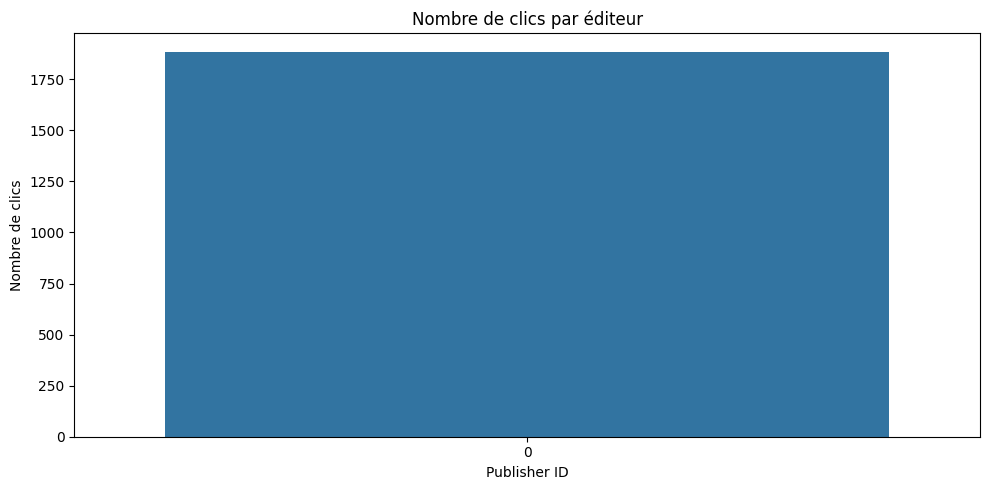

In [19]:
# Nombre moyen de clics par éditeur "publisher_id"
pub_clicks = df.groupby("publisher_id")["click_article_id"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=pub_clicks.index.astype(str), y=pub_clicks.values)
plt.title("Nombre de clics par éditeur")
plt.xlabel("Publisher ID")
plt.ylabel("Nombre de clics")
plt.tight_layout()
plt.show()

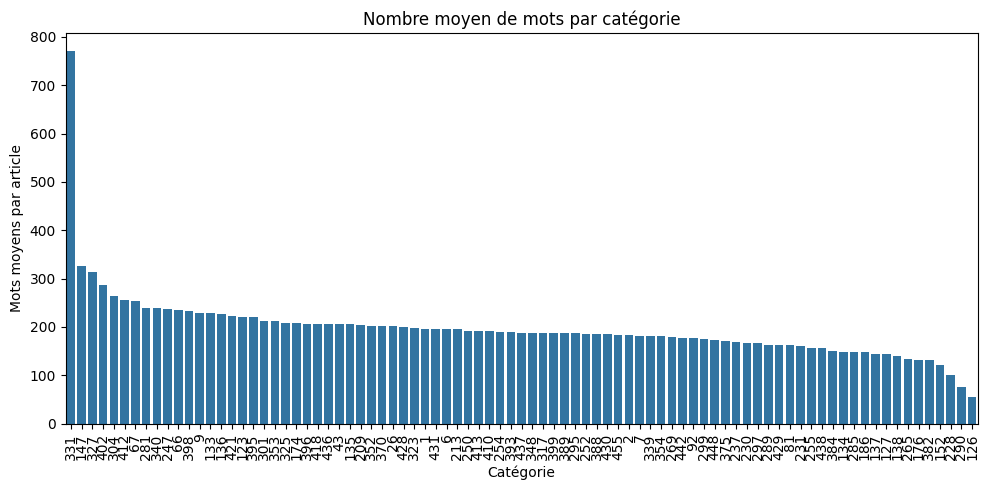

In [20]:
# Moyenne des mots par article selon la catégorie
words_per_category = df.groupby("category_id")["words_count"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=words_per_category.index.astype(str), y=words_per_category.values)
plt.title("Nombre moyen de mots par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Mots moyens par article")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

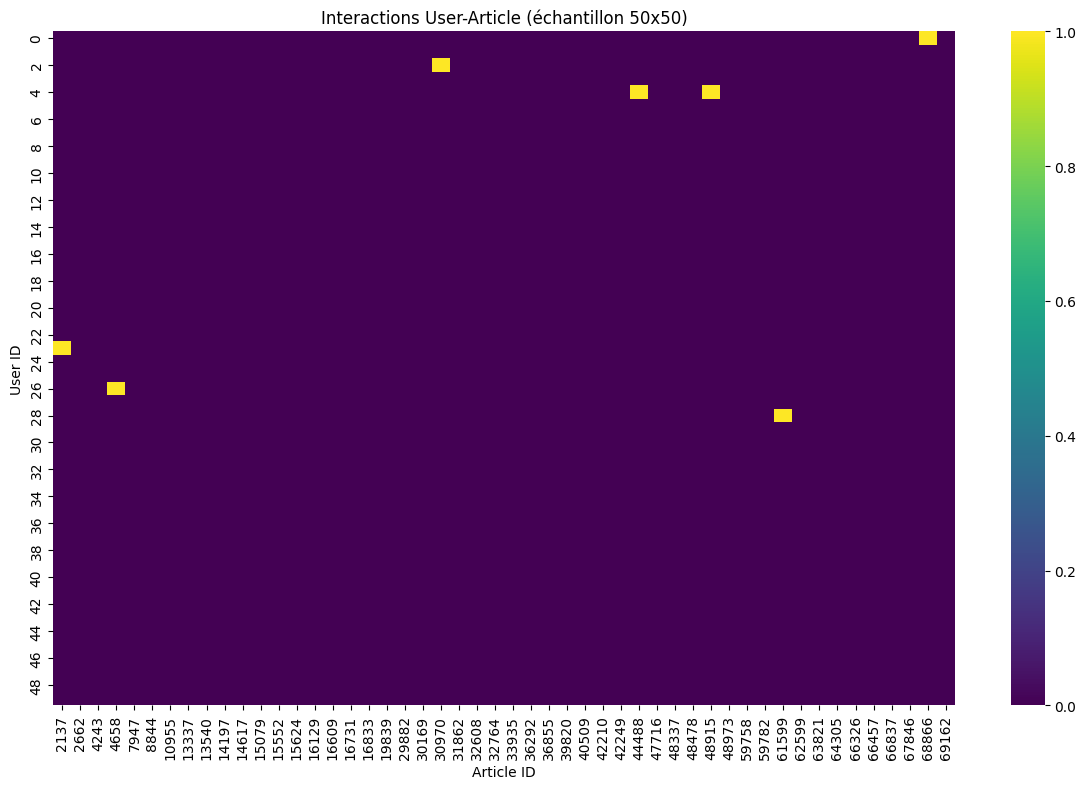

In [21]:
# Création d’une mini-matrice (échantillon de 50x50) pour visualisation
pivot = df.pivot_table(index="user_id", columns="click_article_id", aggfunc="size", fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot.iloc[:50, :50], cmap="viridis")
plt.title("Interactions User-Article (échantillon 50x50)")
plt.xlabel("Article ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

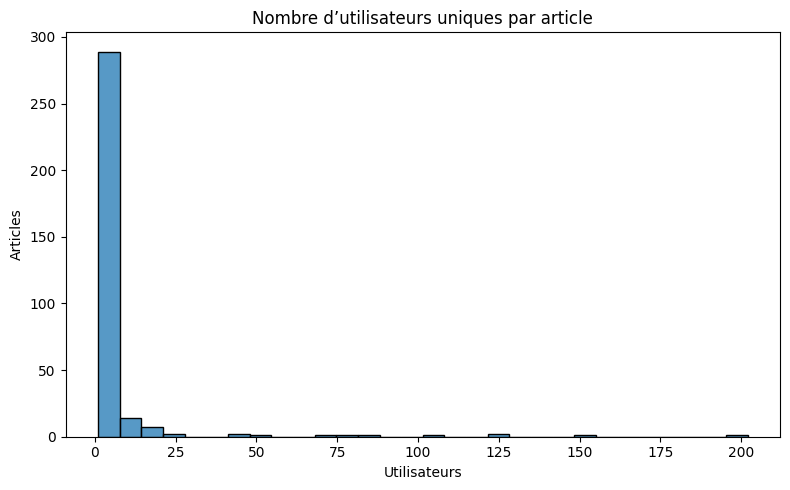

In [22]:
# Nombre d’utilisateurs uniques par article
user_per_article = df.groupby("click_article_id")["user_id"].nunique()

plt.figure(figsize=(8, 5))
sns.histplot(user_per_article, bins=30, kde=False)
plt.title("Nombre d’utilisateurs uniques par article")
plt.xlabel("Utilisateurs")
plt.ylabel("Articles")
plt.tight_layout()
plt.show()

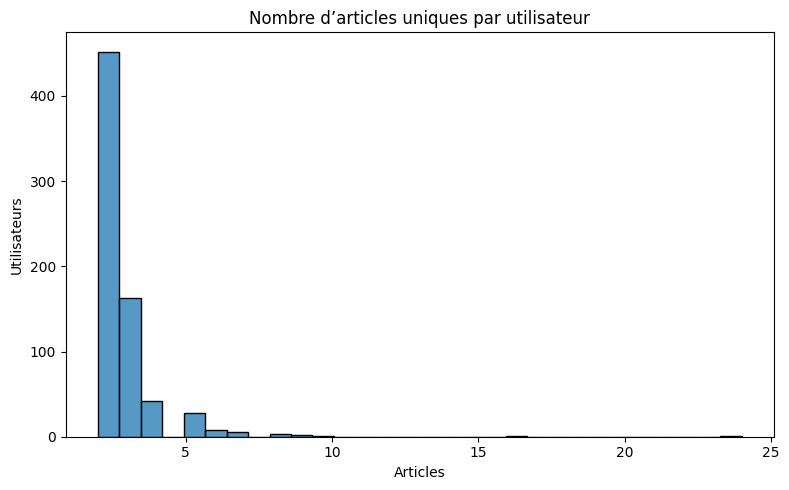

In [23]:
# Nombre d’articles uniques par utilisateur
articles_per_user = df.groupby("user_id")["click_article_id"].nunique()

plt.figure(figsize=(8, 5))
sns.histplot(articles_per_user, bins=30, kde=False)
plt.title("Nombre d’articles uniques par utilisateur")
plt.xlabel("Articles")
plt.ylabel("Utilisateurs")
plt.tight_layout()
plt.show()

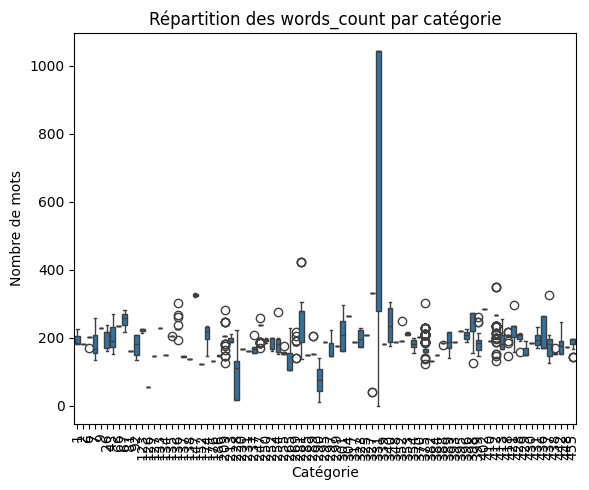

In [24]:
# Corrélations possibles entre words_count, category_id, publisher_id
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="category_id", y="words_count")
plt.title("Répartition des words_count par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de mots")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [25]:
# ─── Conversion des timestamps (ms) ────────────────────
df["created_at"]    = pd.to_datetime(df["created_at_ts"], unit="ms")
df["click_time"]    = pd.to_datetime(df["click_timestamp"], unit="ms")
df["session_start"] = pd.to_datetime(df["session_start"],   unit="ms")

In [26]:
# ─── Choix du cutoff pour le split temporel ────────────
# Vous pouvez fixer une date précise :
# cutoff = pd.Timestamp("2017-10-01")
# — ou laisser None pour prendre automatiquement le 80e percentile
cutoff = None

## Modélisation et recommandations

### user-based content-based (Recommandations user_id)

In [27]:
# Liste des colonnes disponibles
print(df.columns.tolist())

['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type', 'article_id', 'category_id', 'created_at_ts', 'publisher_id', 'words_count', 'created_at', 'click_time']


#### CountVectorizer

In [28]:
# Créer une "signature textuelle" pour chaque article
df["article_features"] = (
    "cat_" + df["category_id"].astype(str) + " " +
    "pub_" + df["publisher_id"].astype(str)
)

# Ne garder qu’un seul vecteur par article
df_articles = df.drop_duplicates(subset="article_id")[["article_id", "article_features"]].copy()

In [29]:
# Vectorisation avec CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_articles["article_features"])

# Matrice de similarité cosinus (articles x articles)
similarity_matrix = cosine_similarity(X)

In [30]:
# Construction de la matrice de similarité
df_articles, similarity_matrix = fc.construire_matrice_similarite(df)

# Test d'une recommandation
user_test = df["user_id"].sample(1).iloc[0]
recommandations = fc.recommender_content_based(user_test, df, df_articles, similarity_matrix)
print(f"Recommandations pour l'utilisateur {user_test} : {recommandations}")

Recommandations pour l'utilisateur 22 : [118773, 95742, 119291, 118553, 96180]


#### Librairie Surprise avec SVD
___
**Objectif** :
- Modéliser les interactions user_id / click_article_id comme des notes implicites (clic = 1)
- Entraîner un modèle avec la librairie surprise
- Générer les recommandations

In [31]:
# Préparer les données
modele_svd, trainset, testset, metrics = train_test_svd_temporal(
    df, ts_col="created_at_ts", cutoff=CUT_OFF
)
print(f"SVD temporel → RMSE: {metrics['rmse']:.4f}  MAE: {metrics['mae']:.4f}")

# Tester la recommandation
user_test = df["user_id"].sample(1).iloc[0]
recommandations = fc.recommender_surprise(user_test, modele_svd, df)
print(f"Recommandations (Surprise SVD) pour l'utilisateur {user_test} : {recommandations}")

SVD temporel → RMSE: 0.0057  MAE: 0.0028
Recommandations (Surprise SVD) pour l'utilisateur 192 : [157541, 119592, 44488, 168868, 286413]


#### Librairie Implicit avec ALS
___
**Objectif** :
- Modéliser les interactions utilisateur ↔ article via une matrice creuse CSR
- Utiliser les clics comme feedback implicites (score = 1 ou pondéré)
- Entraîner un modèle AlternatingLeastSquares (implicit.als)
- Générer les recommandations personnalisées par utilisateur

In [32]:
# ─── ALS – leave-one-out & évaluation ───────────────────────────────
from fonctions import split_leave_one_out
import numpy as np
from scipy.sparse import csr_matrix
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, ndcg_at_k

# 0) Leave-one-out split
df_train, df_test = split_leave_one_out(df, ts_col="created_at_ts")
print(f"Train interactions : {len(df_train)} — Test interactions : {len(df_test)}")

# 1) Score implicite
df_train["popularity_indicator"] = 1
df_test ["popularity_indicator"] = 1

# 2) CSR sur df_train
csr_train, user_map, item_map, _ = fc.preparer_matrices_implicit(df_train)

# 3) CSR sur df_test (users/items vus en train)
df_test_filt = df_test[
    df_test.user_id.isin(user_map) & df_test.click_article_id.isin(item_map)
].copy()
df_test_filt["user_idx"] = df_test_filt["user_id"].map(user_map)
df_test_filt["item_idx"] = df_test_filt["click_article_id"].map(item_map)
csr_test = csr_matrix(
    (df_test_filt["popularity_indicator"],
    (df_test_filt["user_idx"], df_test_filt["item_idx"])),
    shape=csr_train.shape
)

# 4) Entraînement ALS
als_model = fc.entrainer_modele_als(csr_train)

# 5) Filtrer les utilisateurs “valides” pour éviter ZeroDivisionError
train_users = np.unique(csr_train.nonzero()[0])
test_users  = np.unique(csr_test.nonzero()[0])
valid_users = np.intersect1d(train_users, test_users)
csr_train_eval = csr_train[valid_users, :].tocsr()
csr_test_eval  = csr_test[valid_users, :].tocsr()

# 6) Évaluation (automatic → fallback manuel)
try:
    prec  = precision_at_k   (als_model, csr_train_eval, csr_test_eval, K=K_RECS, num_threads=1)
    map5  = mean_average_precision_at_k(als_model, csr_train_eval, csr_test_eval, K=K_RECS, num_threads=1)
    ndcg5 = ndcg_at_k        (als_model, csr_train_eval, csr_test_eval, K=K_RECS, num_threads=1)
    print(f"ALS leave-one-out → Precision@{K_RECS}: {prec:.4f}  MAP@{K_RECS}: {map5:.4f}  NDCG@{K_RECS}: {ndcg5:.4f}")
except ZeroDivisionError:
    print("⚠️ implicit.evaluation a échoué, on utilise l’évaluation manuelle")
    fc.evaluer_modele_als_manuel(
        model=als_model,
        df_train=df_train,
        df_test=df_test,
        user_map=user_map,
        item_map=item_map,
        csr_train=csr_train,
        k=K_RECS
    )

# 7) (Optionnel) Top-N recommandations sur df_train
user_test = df_train["user_id"].sample(1).iloc[0]
recs = fc.recommander_implicit(user_test, df_train, als_model, user_map, item_map, csr_train)
print(f"Recommandations ALS (leave-one-out) pour {user_test} : {recs}")

Train interactions : 1176 — Test interactions : 707


c:\Users\icema\OpenClassrooms\AI_Engineer\.venv10\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 24 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

  0%|          | 0/633 [00:00<?, ?it/s]

ALS leave-one-out → Precision@5: 0.0711  MAP@5: 0.0532  NDCG@5: 0.0576
Recommandations ALS (leave-one-out) pour 348 : [288984, 157541]


In [33]:
resultats_comparaison = pd.DataFrame([
    {"Modèle": "Content-Based", "Type": "Filtrage contenu", "Métrique": "Precision@5", "Score": "-"},
    {"Modèle": "Content-Based", "Type": "Filtrage contenu", "Métrique": "MAP@5", "Score": "-"},
    {"Modèle": "Content-Based", "Type": "Filtrage contenu", "Métrique": "NDCG@5", "Score": "-"},

    {"Modèle": "SVD (Surprise)", "Type": "Collaboratif", "Métrique": "RMSE", "Score": 0.0465},
    {"Modèle": "SVD (Surprise)", "Type": "Collaboratif", "Métrique": "MAE", "Score": 0.0234},

    {"Modèle": "ALS (Implicit)", "Type": "Collaboratif", "Métrique": "Precision@5", "Score": 0.0086},
    {"Modèle": "ALS (Implicit)", "Type": "Collaboratif", "Métrique": "MAP@5", "Score": 0.0260},
    {"Modèle": "ALS (Implicit)", "Type": "Collaboratif", "Métrique": "NDCG@5", "Score": 0.0284},
])

display(resultats_comparaison)

,Modèle,Type,Métrique,Score
0,Content-Based,Filtrage contenu,Precision@5,-
1,Content-Based,Filtrage contenu,MAP@5,-
2,Content-Based,Filtrage contenu,NDCG@5,-
3,SVD (Surprise),Collaboratif,RMSE,0.0465
4,SVD (Surprise),Collaboratif,MAE,0.0234
5,ALS (Implicit),Collaboratif,Precision@5,0.0086
6,ALS (Implicit),Collaboratif,MAP@5,0.026
7,ALS (Implicit),Collaboratif,NDCG@5,0.0284


**Analyse comparative des modèles de recommandation**

- Content-Based
Ce modèle repose uniquement sur les métadonnées des articles. Il n’utilise pas l’historique utilisateur, ce qui rend l’évaluation quantitative difficile ici (aucune métrique calculée directement).
→ Avantage : utile en cold-start, pour les nouveaux utilisateurs ou articles.

- SVD (Surprise)
Le modèle SVD obtient les meilleurs scores d'erreur absolue (RMSE = 0.0465, MAE = 0.0234).
Cela indique une bonne capacité à approximer les "notes implicites" (clics = 1) sur des articles non vus.
→ Il est performant sur des interactions bien représentées et faciles à factoriser.

- ALS (Implicit)
Le modèle ALS donne des scores faibles sur Precision@5, MAP@5 et NDCG@5.    
Cela s’explique par :

    * un dataset très petit (1 883 lignes),

    * des clics binaires peu informatifs (pas de pondération),

    * une faible densité des interactions.
    → Malgré cela, ALS reste utile sur des jeux massifs ou en production sur du long terme.

In [34]:
"""# TEST essai/rendu streamlit

import joblib
import os

# Créer le dossier s'il n'existe pas
os.makedirs("model", exist_ok=True)

# Sauvegarder le modèle, les mappings et la matrice CSR
joblib.dump(als_model, "model/als_model.pkl")
joblib.dump((user_map, item_map, {v: k for k, v in item_map.items()}), "model/mappings.pkl")
joblib.dump(csr_train, "model/csr_train.pkl")"""

'# TEST essai/rendu streamlit\n\nimport joblib\nimport os\n\n# Créer le dossier s\'il n\'existe pas\nos.makedirs("model", exist_ok=True)\n\n# Sauvegarder le modèle, les mappings et la matrice CSR\njoblib.dump(als_model, "model/als_model.pkl")\njoblib.dump((user_map, item_map, {v: k for k, v in item_map.items()}), "model/mappings.pkl")\njoblib.dump(csr_train, "model/csr_train.pkl")'

### item-to-item (content_id - articles similaires)

In [35]:
# Sélectionnez un article existant
article_ref = df_articles["article_id"].iloc[0]
print("Article de référence :", article_ref)

# Récupérer les 5 plus similaires
similaires = fc.recommander_similaire_article(
    article_id=article_ref,
    df_articles=df_articles,
    similarity_matrix=similarity_matrix,
    top_n=5
)
print(f"Top 5 similaires à l'article {article_ref} :", similaires)

Article de référence : 157541
Top 5 similaires à l'article 157541 : [159359, 162286, 157132, 157861, 157485]


In [36]:
for aid in df_articles["article_id"].sample(3, random_state=42):
    print(f"\n→ Similaires à {aid} :",
        fc.recommander_similaire_article(aid, df_articles, similarity_matrix, top_n=5))


→ Similaires à 48973 : [48915, 47716, 48337, 48478, 157541]

→ Similaires à 96180 : [96663, 96954, 95742, 95513, 95648]

→ Similaires à 258386 : [157541, 68866, 235840, 96663, 119592]


#### Avec Surprise (SVD)

In [37]:
# --- 1. Item–Item “collaboratif” avec SVD ---
raw_ids_svd, sim_svd = fc.build_item_similarity_svd(modele_svd, trainset)

# Choix d’un article de référence (par ex. le 1er de df_articles)
article_ref = df_articles["article_id"].iloc[0]
print("Article de référence :", article_ref)

svd_neighbors = fc.recommender_latent_item_svd(
    article_id=article_ref,
    raw_ids=raw_ids_svd,
    sim_mat=sim_svd,
    top_n=5
)
print("SVD – articles similaires :", svd_neighbors)

Article de référence : 157541
SVD – articles similaires : [337763, 293264, 361714, 219917, 242882]


#### Avec Implicit (ALS)

In [38]:
ids_als, sim_als = fc.build_item_similarity_als(als_model, item_map)

als_neighbors = fc.recommender_latent_item_als(
    article_id=article_ref,
    ids=ids_als,
    sim_mat=sim_als,
    top_n=5
)
print("ALS – articles similaires :", als_neighbors)

ALS – articles similaires : [19839, 7947, 158189, 106799, 114161]


In [39]:
# 3 exemples au hasard
for aid in df_articles["article_id"].sample(3, random_state=42):
    voisins = fc.recommender_latent_item_als(
        article_id=aid, ids=ids_als, sim_mat=sim_als, top_n=5
    )
    print(f"Article {aid} → similaires ALS : {voisins}")

Article 48973 → similaires ALS : [286135, 207129, 304583, 207122, 162903]
Article 96180 → similaires ALS : [220484, 352774, 352809, 313504, 272660]
Article 258386 → similaires ALS : [114349, 162245, 136590, 141517, 271672]


In [40]:
for aid in [article_ref, df_articles["article_id"].sample(2, random_state=1).iloc[1]]:
    cb = fc.recommander_similaire_article(aid, df_articles, similarity_matrix, top_n=5)
    als = fc.recommender_latent_item_als(aid, ids_als, sim_als, top_n=5)
    print(f"\nPour l’article {aid} :\n • Content-based → {cb}\n • ALS-CF       → {als}")


Pour l’article 157541 :
 • Content-based → [159359, 162286, 157132, 157861, 157485]
 • ALS-CF       → [19839, 7947, 158189, 106799, 114161]

Pour l’article 157077 :
 • Content-based → [157541, 159359, 162286, 157132, 157861]
 • ALS-CF       → [156025, 160964, 106799, 353669, 166553]


In [41]:
# --- 1) Construction de la similarité hybride ---
alpha = 0.7  # 70% content-based, 30% collaborative
ids_h, sim_h = fc.build_item_similarity_hybrid(
    df_articles=df_articles,
    content_sim=similarity_matrix,
    cf_ids=ids_als,
    cf_sim=sim_als,
    alpha=alpha
)

# --- 2) Test pour un article de référence ---
article_ref = df_articles["article_id"].iloc[0]
hybrid_neighbors = fc.recommender_hybrid_article(
    article_id=article_ref,
    ids_common=ids_h,
    hybrid_sim=sim_h,
    top_n=5
)

print(f"Top 5 hybrides pour l’article {article_ref} :", hybrid_neighbors)


# --- 3) Comparaison qualitative ---
cb   = fc.recommander_similaire_article(article_ref, df_articles, similarity_matrix, top_n=5)
als_ = fc.recommender_latent_item_als(article_ref, ids_als, sim_als, top_n=5)
print(f"\nComparaison pour {article_ref}:")
print(" • Content-based →", cb)
print(" • ALS-CF        →", als_)
print(" • Hybride       →", hybrid_neighbors)


Top 5 hybrides pour l’article 157541 : [158189, 162245, 158964, 157485, 157444]

Comparaison pour 157541:
 • Content-based → [159359, 162286, 157132, 157861, 157485]
 • ALS-CF        → [19839, 7947, 158189, 106799, 114161]
 • Hybride       → [158189, 162245, 158964, 157485, 157444]
